# Models for Win / Loose determination based on one player's data

## Import MatPlotLib & Setup

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import Keras, Pandas & other used libraries

In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import xgboost as xgb


## Import Data

In [4]:
df_game_players_normalized_features = pd.read_csv("../data/processed/game_players_normalized_features.csv")
df_game_players_normalized_features.head()

df_game_players_normalized_features_columns = df_game_players_normalized_features.columns


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_game_players_normalized_features.head()

,game_id,player_id,role,champion_name,win,KLA,gold_pm,lvl_pm,creep_score_pm,wards_pm,damage_pm,damage_to_champions_pm,damage_taken_pm,greatest_killing_spree,greatest_multi_kill
0,15,0,Top,Irelia,False,-0.850078,0.017216,0.570287,0.378554,-0.556939,-0.250152,-0.379895,0.178004,-0.785460,-0.074661
1,15,1,Top,Vladimir,True,-0.452210,0.034336,1.811131,0.310054,-0.315048,-0.227479,0.131667,0.366546,0.102038,-0.074661
2,15,2,Bot,Kai'Sa,False,-0.717456,0.546958,0.570287,1.036154,-0.476309,0.045370,-0.538908,-1.387111,-0.785460,-0.074661
3,15,4,Mid,Aatrox,True,-0.275380,0.797399,1.811131,0.501854,-0.395679,0.191687,0.112836,0.203438,0.545787,1.124582
4,15,5,Support,Alistar,True,0.608771,-0.430350,0.570287,-1.457245,0.813776,-1.467484,-1.257605,-0.971957,-0.785460,-0.074661


## Preprocessing data for win determination with one player's data

In [5]:
def get_useful_players_data(dataframe : pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame()
    
    new_df = dataframe[useful_player_columns_num]
    
    return new_df

def get_solo_player_data(player_id : int, game_id : int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    df_player = df_game_players_normalized_features[df_game_players_normalized_features['game_id'] == game_id]
    
    # Filter by player_id
    df_player = df_player[df_player['player_id'] == player_id]
    
    df_player_selected = get_useful_players_data(df_player)
    
    return df_player_selected

useful_player_columns_num = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

win_loose_preprocessor = make_column_transformer((FunctionTransformer(None), useful_player_columns_num))

player_roles = ['Top', 'Jungle', 'Mid', 'Support', 'Bot']


def group_split(X: pd.DataFrame, y: pd.Series, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

def get_role_data(role: str, test_game_id: int | None = None) -> tuple:
    
    df_game_players_normalized_features.head()
    
    X = df_game_players_normalized_features.loc[df_game_players_normalized_features['role'] == role].copy()
    
    if test_game_id is not None:
        X = X.loc[X['game_id'] != test_game_id].copy()
    
    y = X['win'].copy()
    group = X['game_id'].copy()
    
    X = get_useful_players_data(X)
    
    X_train, X_valid, y_train, y_valid = group_split(X, y, group)
    
    X_train = win_loose_preprocessor.fit_transform(X_train)
    X_valid = win_loose_preprocessor.transform(X_valid)
    
    return X_train, X_valid, y_train, y_valid

## Create the model

In [6]:
def get_models(input_shape: int, random_state = 42) -> keras.Model:
    tree_model = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=random_state
    )
    
    xgb_model = xgb.XGBClassifier(
        max_depth=5,
        n_estimators=100,
        learning_rate=0.1,
        random_state=random_state,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    sequential_model_1 = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[input_shape]),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')   
    ])
    
    sequential_model_2 = keras.Sequential([
        layers.Dense(128, input_shape=[input_shape]),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(32),
        layers.LeakyReLU(alpha=0.01),
        layers.Dense(1, activation='sigmoid')
    ])
    
    sequential_model_3 = keras.Sequential([
        layers.Dense(256, input_shape=[input_shape]),
        layers.Activation('swish'),
        layers.Dense(128),
        layers.Activation('swish'),
        layers.Dense(64),
        layers.Activation('swish'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    sequential_model_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    sequential_model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    sequential_model_3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    return {
        'tree': tree_model,
        'xgboost': xgb_model,
        'sequential': {'1': sequential_model_1,'2': sequential_model_2,'3': sequential_model_3  }
    }

def train_models(X_train, X_valid, y_train, y_valid, models, epochs=10, batch_size=128):
    results = {}
    
    # Train decision tree
    models["tree"].fit(X_train, y_train)
    tree_train_score = models["tree"].score(X_train, y_train)
    tree_valid_score = models["tree"].score(X_valid, y_valid)
    results["tree"] = {"train_accuracy": tree_train_score, "valid_accuracy": tree_valid_score}
    
    # Train XGBoost
    models["xgboost"].fit(X_train, y_train, 
                         eval_set=[(X_valid, y_valid)],
                         verbose=False)
    xgb_train_score = models["xgboost"].score(X_train, y_train)
    xgb_valid_score = models["xgboost"].score(X_valid, y_valid)
    results["xgboost"] = {"train_accuracy": xgb_train_score, "valid_accuracy": xgb_valid_score}
    
    # Train sequential model
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )
    
    histories = {}
    for key, model in models["sequential"].items():
        histories[key] = model.fit(
            X_train, y_train, 
            validation_data=(X_valid, y_valid), 
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[early_stopping],
            verbose=0
        )
    
    # Get the sequential model's performance
    seq_train_scores = {}
    seq_valid_scores = {}
    best_seq_valid = 0
    best_seq_key = None
    
    for key, model in models["sequential"].items():
        seq_train_scores[key] = model.evaluate(X_train, y_train, verbose=0)[1]
        seq_valid_scores[key] = model.evaluate(X_valid, y_valid, verbose=0)[1]
        
        # Track the best sequential model
        if seq_valid_scores[key] > best_seq_valid:
            best_seq_valid = seq_valid_scores[key]
            best_seq_key = key
    
    # Store all sequential results
    results["sequential"] = {
        "train_accuracy": seq_train_scores, 
        "valid_accuracy": seq_valid_scores,
        "histories": histories,
        "best_key": best_seq_key,
        "best_valid_accuracy": best_seq_valid  # Add the best valid accuracy for comparison
    }
    
    # Determine best model based on validation accuracy
    max_valid = 0
    best_model_type = None
    
    # Compare tree
    if results["tree"]["valid_accuracy"] > max_valid:
        max_valid = results["tree"]["valid_accuracy"]
        best_model_type = "tree"
        best_model_instance = models["tree"]
    
    # Compare XGBoost
    if results["xgboost"]["valid_accuracy"] > max_valid:
        max_valid = results["xgboost"]["valid_accuracy"]
        best_model_type = "xgboost"
        best_model_instance = models["xgboost"]
    
    # Compare with best sequential
    if best_seq_valid > max_valid:
        best_model_type = "sequential"
        best_model_instance = models["sequential"][best_seq_key]
    
    return models, results, best_model_type, best_model_instance, best_seq_key

## Visualize model training results

In [7]:
def visualize_model_results(results, best_model_type, best_seq_key=None):
    """
    Visualize model results with comparison charts and history plots.
    
    Parameters:
    - results: Dictionary containing results from all models
    - best_model_type: String indicating the best model type (tree, xgboost, or sequential)
    - best_seq_key: String key of the best sequential model (if applicable)
    
    Returns:
    - fig: The created matplotlib figure
    """
    # Print results
    print(f"Results:")
    print(f"  tree: train acc={results['tree']['train_accuracy']:.4f}, valid acc={results['tree']['valid_accuracy']:.4f}")
    print(f"  xgboost: train acc={results['xgboost']['train_accuracy']:.4f}, valid acc={results['xgboost']['valid_accuracy']:.4f}")
    print(f"  sequential models:")
    for key, score in results['sequential']['train_accuracy'].items():
        valid_score = results['sequential']['valid_accuracy'][key]
        print(f"    model {key}: train acc={score:.4f}, valid acc={valid_score:.4f}")
    
    if best_model_type == "sequential" and best_seq_key is not None:
        print(f"Best model: {best_model_type} - {best_seq_key}")
    else:
        print(f"Best model: {best_model_type}")

    # Create visualization
    fig = plt.figure(figsize=(18, 10))

    # Create a grid layout
    gs = fig.add_gridspec(2, 3)

    # Bar chart for all models comparison (spans top row)
    ax1 = fig.add_subplot(gs[0, :])

    # Prepare data for bar chart
    model_names = ['tree', 'xgboost']
    train_acc = [results['tree']['train_accuracy'], results['xgboost']['train_accuracy']]
    valid_acc = [results['tree']['valid_accuracy'], results['xgboost']['valid_accuracy']]

    # Add each sequential model to the comparison
    for key in results['sequential']['train_accuracy'].keys():
        model_names.append(f'seq-{key}')
        train_acc.append(results['sequential']['train_accuracy'][key])
        valid_acc.append(results['sequential']['valid_accuracy'][key])

    # Plot bar chart
    x = range(len(model_names))
    width = 0.35
    ax1.bar([i - width/2 for i in x], train_acc, width, label='Train')
    ax1.bar([i + width/2 for i in x], valid_acc, width, label='Valid')
    ax1.set_title('Model Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.set_ylim(0, 1)
    ax1.legend()

    # Add subplots for each sequential model's history
    if 'histories' in results['sequential']:
        histories = results['sequential']['histories']
        
        # Plot loss for all sequential models
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.set_title('Sequential Models - Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        
        # Plot accuracy for all sequential models
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.set_title('Sequential Models - Training Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        
        # Plot validation accuracy for all sequential models
        ax4 = fig.add_subplot(gs[1, 2])
        ax4.set_title('Sequential Models - Validation Accuracy')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        
        # Plot each model's history with different colors
        colors = ['blue', 'green', 'red']
        for i, (key, history) in enumerate(histories.items()):
            color = colors[i % len(colors)]
            epochs = range(1, len(history.history['loss'])+1)
            
            # Loss plot
            ax2.plot(epochs, history.history['loss'], f'-', color=color, label=f'Train-{key}')
            ax2.plot(epochs, history.history['val_loss'], f'--', color=color, label=f'Valid-{key}')
            
            # Training accuracy plot
            ax3.plot(epochs, history.history['binary_accuracy'], f'-', color=color, label=f'Model-{key}')
            
            # Validation accuracy plot
            ax4.plot(epochs, history.history['val_binary_accuracy'], f'-', color=color, label=f'Model-{key}')
        
        ax2.legend()
        ax3.legend()
        ax4.legend()

    plt.tight_layout()
    plt.show()
    
    return fig

## Data fetching for Top role

In [8]:
df_game_players_normalized_features.head()

print(player_roles)

top_X_train, top_X_valid, top_y_train, top_y_valid = get_role_data(player_roles[0], 0)

jungle_input_shape = [top_X_train.shape[1]]
print("Input shape: {}".format(jungle_input_shape))

# print("First 5 elements of X:")
# print(X[:5])
# print("\nFirst 5 elements of y:")
# print(y[:5])

['Top', 'Jungle', 'Mid', 'Support', 'Bot']
Input shape: [10]


## 'Top' Model training 

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:07:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8753, valid acc=0.8721
  xgboost: train acc=0.9055, valid acc=0.8980
  sequential models:
    model 1: train acc=0.9017, valid acc=0.9006
    model 2: train acc=0.9037, valid acc=0.9019
    model 3: train acc=0.9012, valid acc=0.9031
Best model: sequential - 3


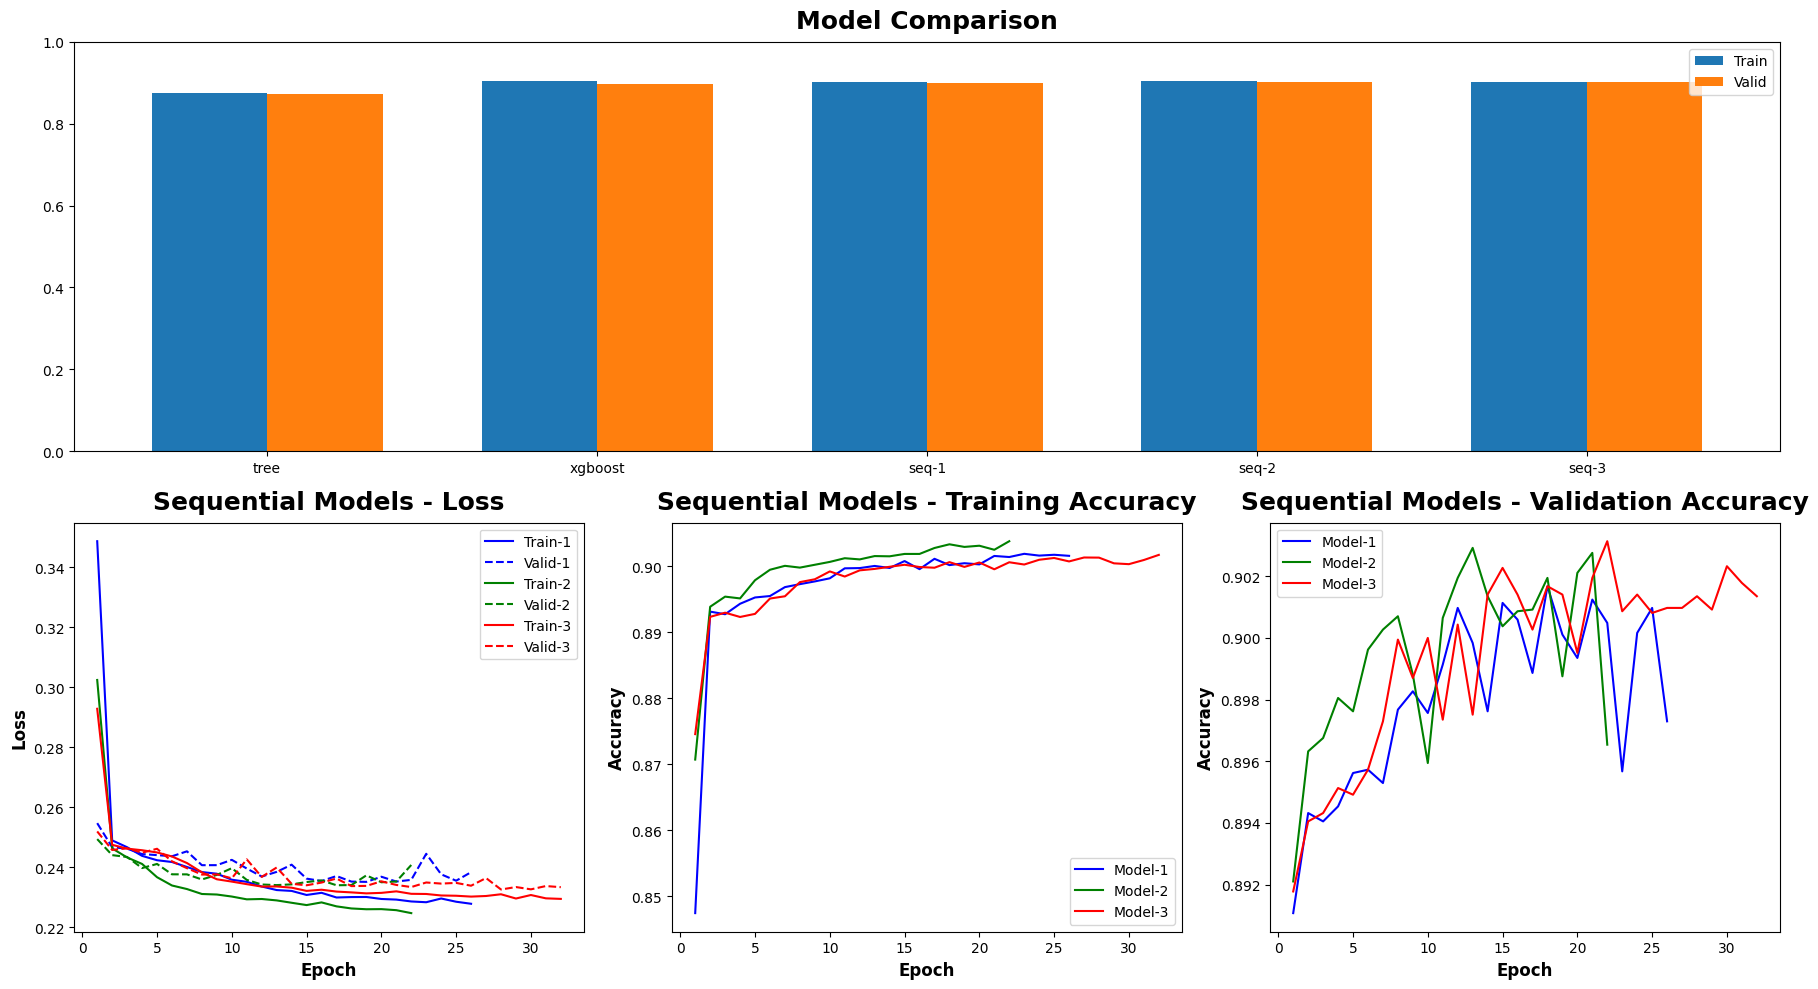

In [9]:
# Top model training
top_models = get_models(jungle_input_shape[0])
top_models, top_results, top_best_model_type, top_best_model, top_best_seq_key = train_models(
    top_X_train, top_X_valid, top_y_train, top_y_valid, top_models,
    epochs=100, batch_size=256
)

# Visualize results
fig = visualize_model_results(top_results, top_best_model_type, top_best_seq_key)

After looking at the result we can select the model from the 3 best, in our case we will select the second squential model

## Test 'Top' model

In [10]:
# Test with the player id 21:
top_X_test_1 = get_solo_player_data(21, 0)
top_X_test_2 = get_solo_player_data(29, 0)
    
top_X_test_1_preprocessed = win_loose_preprocessor.transform(top_X_test_1)
top_X_test_2_preprocessed = win_loose_preprocessor.transform(top_X_test_2)

# Make predictions
if top_best_model_type == "sequential":
    top_best_model = top_models["sequential"][top_best_seq_key]
    
    top_prediction_1 = top_best_model.predict(top_X_test_1_preprocessed)
    top_prediction_2 = top_best_model.predict(top_X_test_2_preprocessed)

# For a binary classification, you may want to interpret the outputs
top_predicted_win_1 = top_prediction_1[0][0] > 0.5
top_predicted_win_2 = top_prediction_2[0][0] > 0.5
print(f"Predicted outcome for player 21: {'Win' if top_predicted_win_1 else 'Loss'}")
print(f"Predicted outcome for player 29: {'Win' if top_predicted_win_2 else 'Loss'}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted outcome for player 21: Win
Predicted outcome for player 29: Loss


## Data fetching for 'Jungle' role

In [11]:
jungle_X_train, jungle_X_valid, jungle_y_train, jungle_y_valid = get_role_data(player_roles[1])

jungle_input_shape = [jungle_X_train.shape[1]]
print("Input shape: {}".format(jungle_input_shape))

Input shape: [10]


## 'Jungle' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8828, valid acc=0.8842
  xgboost: train acc=0.9149, valid acc=0.9105
  sequential models:
    model 1: train acc=0.9104, valid acc=0.9138
    model 2: train acc=0.9100, valid acc=0.9124
    model 3: train acc=0.9098, valid acc=0.9133
Best model: sequential - 1


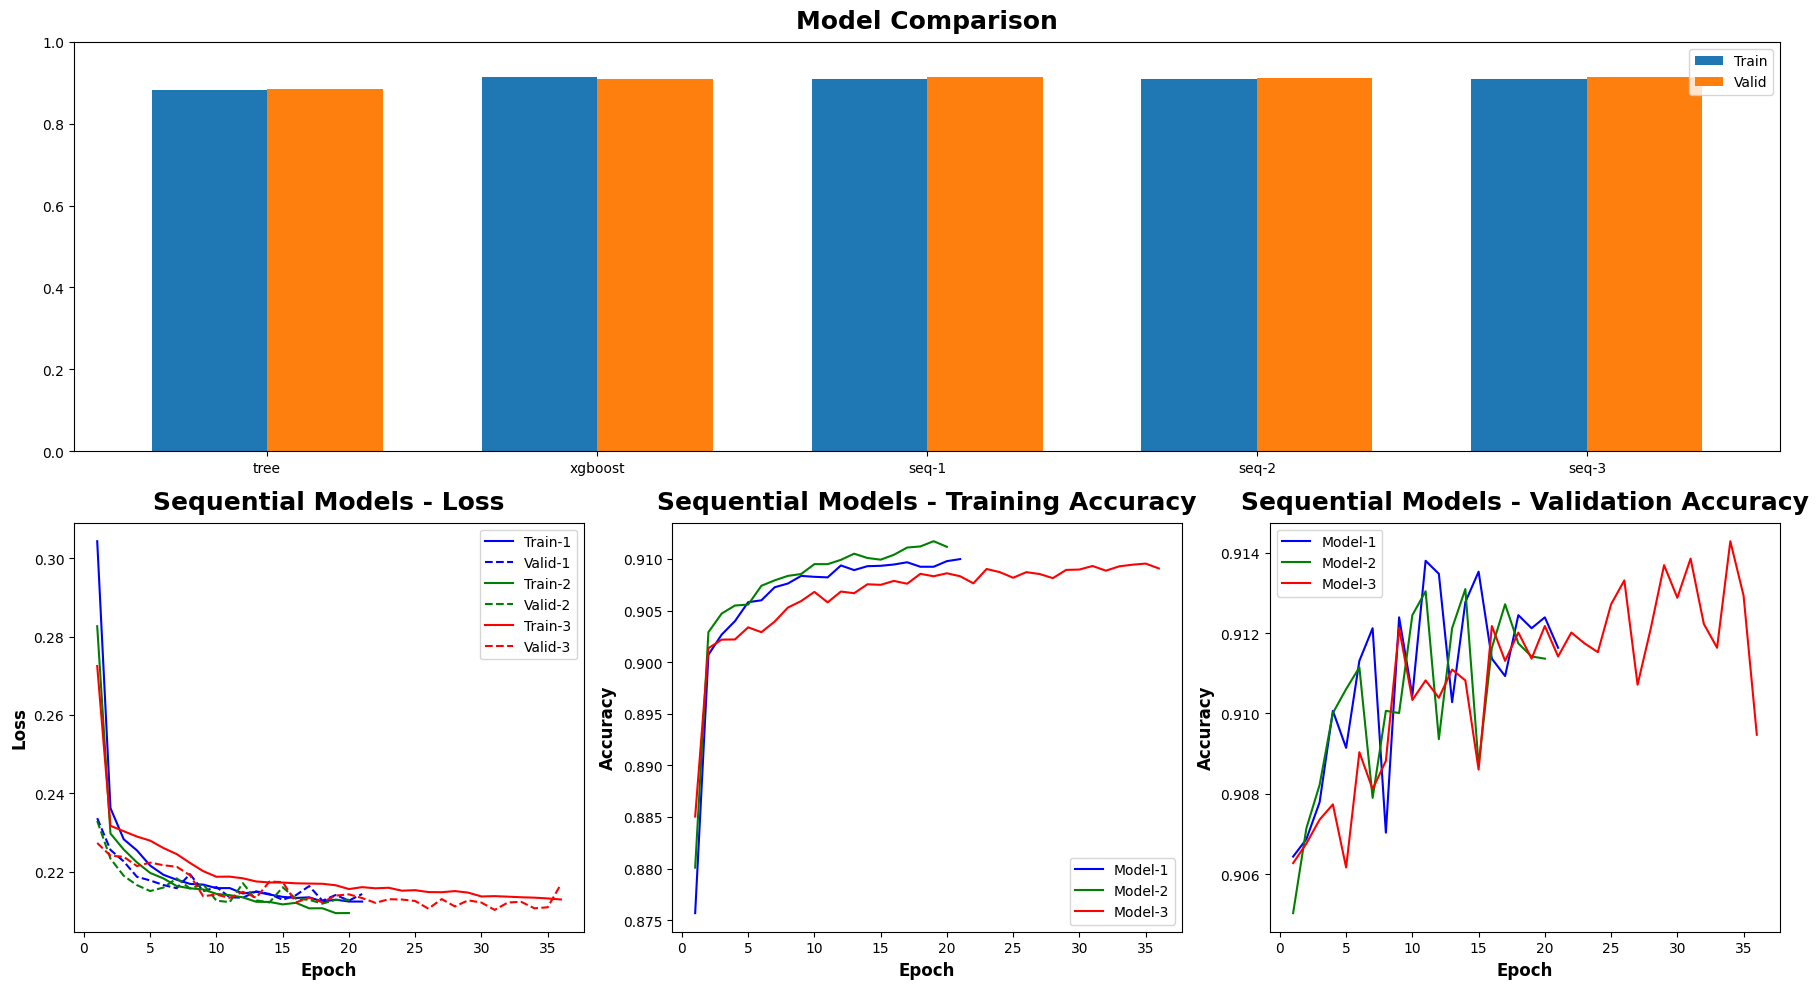

In [12]:
jungle_models = get_models(jungle_input_shape[0])
jungle_models, jungle_results, jungle_best_model_type, jungle_best_model, jungle_best_seq_key = train_models(
    jungle_X_train, jungle_X_valid, jungle_y_train, jungle_y_valid, jungle_models, 
    epochs=100, batch_size=256
)

# Visualize jungle results
fig = visualize_model_results(jungle_results, jungle_best_model_type, jungle_best_seq_key)

## Data fetching for 'Middle' role

In [13]:
mid_X_train, mid_X_valid, mid_y_train, mid_y_valid = get_role_data(player_roles[2])

mid_input_shape = [mid_X_train.shape[1]]
print("Input shape: {}".format(mid_input_shape))

Input shape: [10]


## 'Middle' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:08:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8779, valid acc=0.8716
  xgboost: train acc=0.9141, valid acc=0.9036
  sequential models:
    model 1: train acc=0.9090, valid acc=0.9043
    model 2: train acc=0.9092, valid acc=0.9044
    model 3: train acc=0.9071, valid acc=0.9048
Best model: sequential - 3


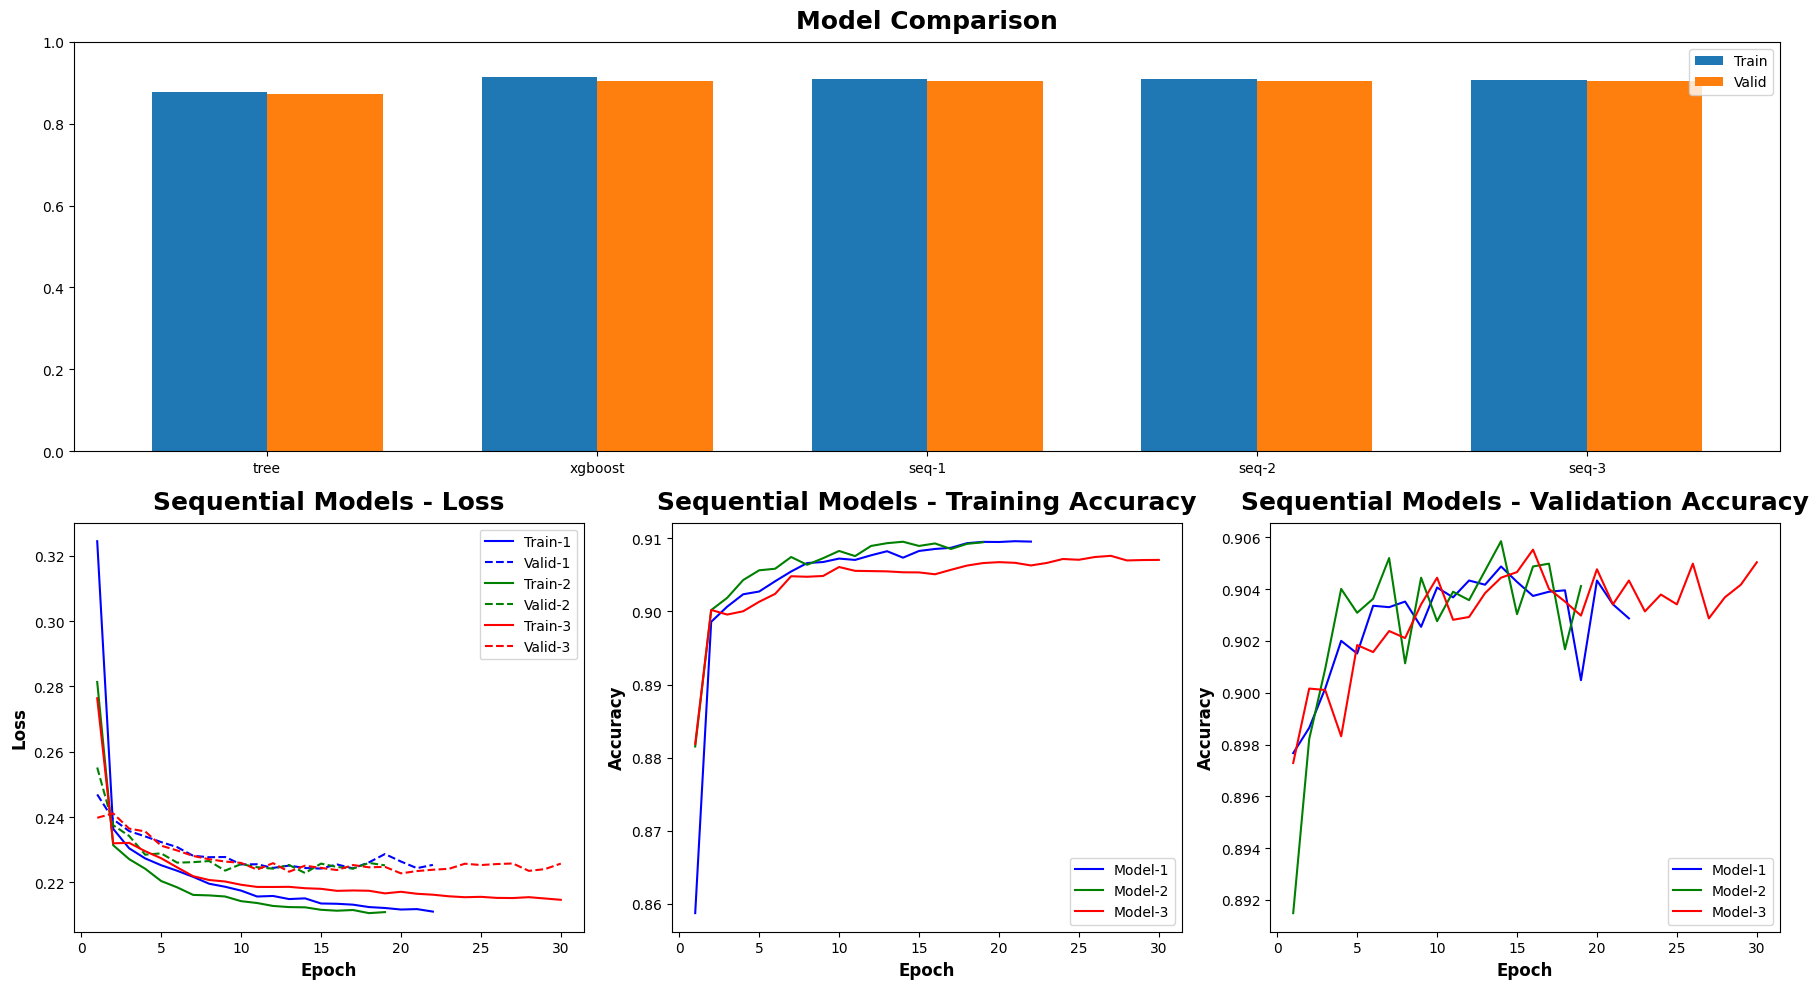

In [14]:
mid_models = get_models(mid_input_shape[0])
mid_models, mid_results, mid_best_model_type, mid_best_model, mid_best_seq_key = train_models(
    mid_X_train, mid_X_valid, mid_y_train, mid_y_valid, mid_models, 
    epochs=100, batch_size=256
)

# Visualize mid results
fig = visualize_model_results(mid_results, mid_best_model_type, mid_best_seq_key)

## Data fetching for 'Support' role

In [15]:
sup_X_train, sup_X_valid, sup_y_train, sup_y_valid = get_role_data(player_roles[2])

sup_input_shape = [sup_X_train.shape[1]]
print("Input shape: {}".format(sup_input_shape))

Input shape: [10]


## 'Support' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:09:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8751, valid acc=0.8764
  xgboost: train acc=0.9132, valid acc=0.9050
  sequential models:
    model 1: train acc=0.9078, valid acc=0.9061
    model 2: train acc=0.9101, valid acc=0.9066
    model 3: train acc=0.9057, valid acc=0.9050
Best model: sequential - 2


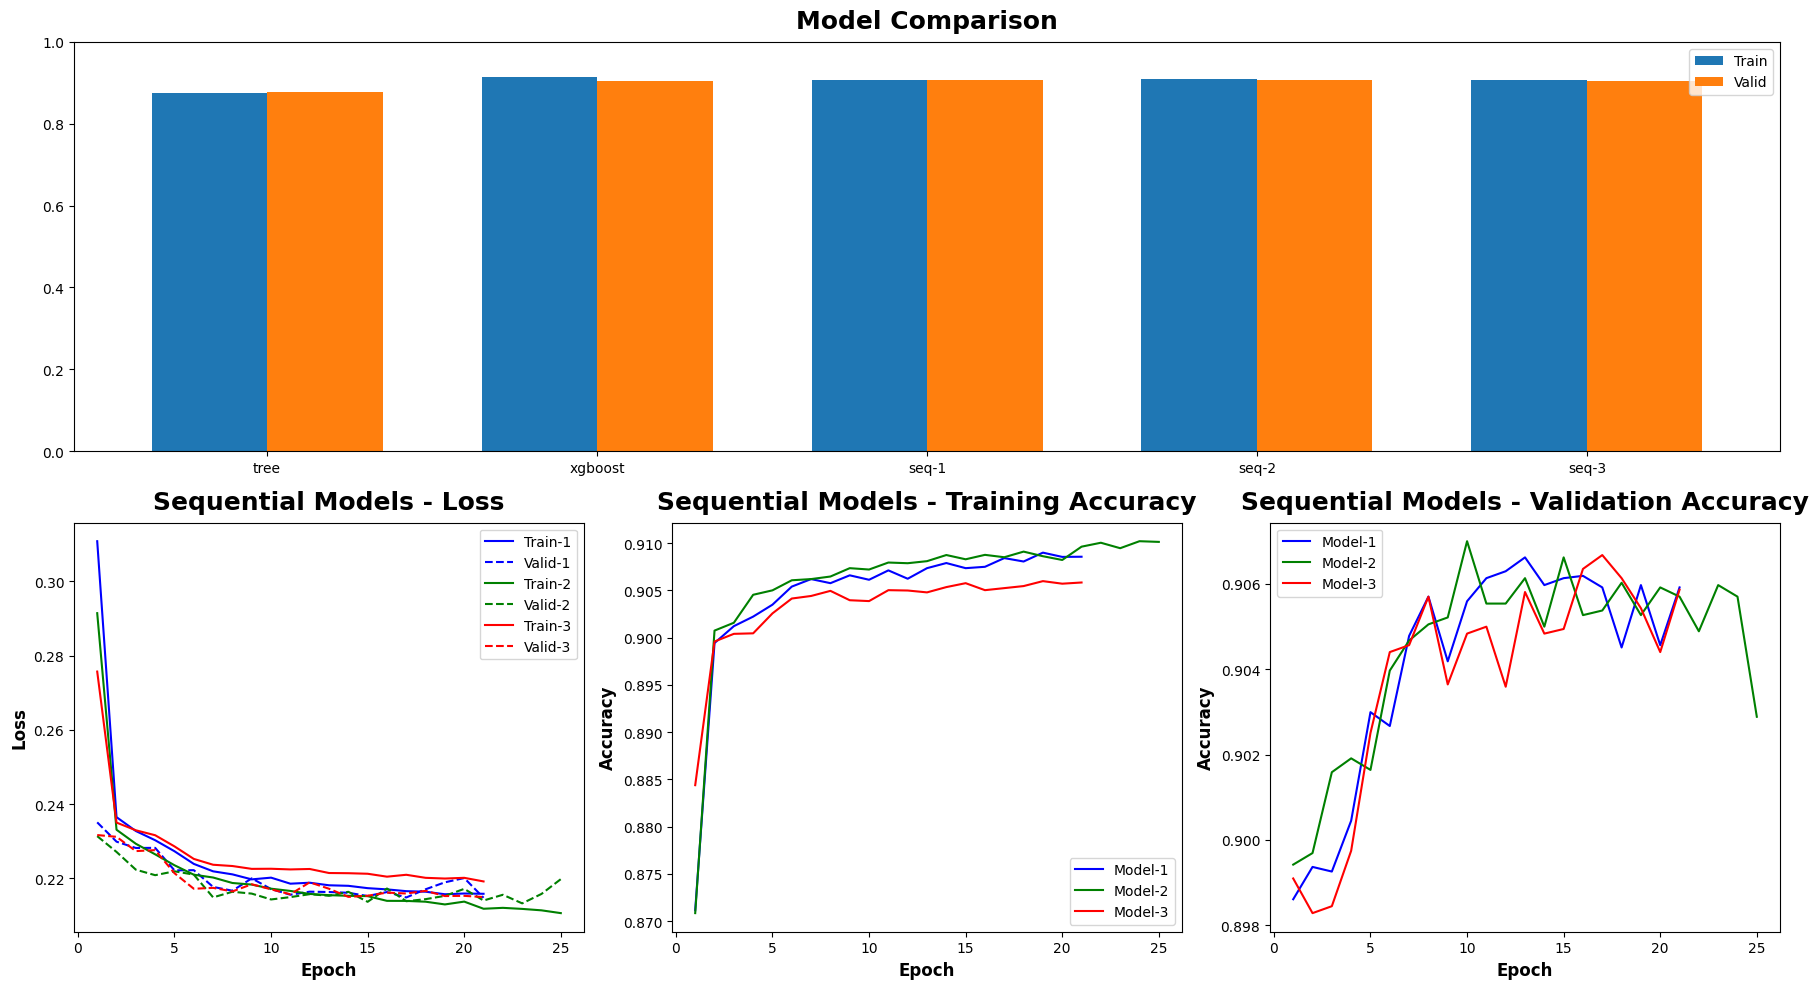

In [16]:
sup_models = get_models(sup_input_shape[0])
sup_models, sup_results, sup_best_model_type, sup_best_model, sup_best_seq_key = train_models(
    sup_X_train, sup_X_valid, sup_y_train, sup_y_valid, sup_models, 
    epochs=100, batch_size=256
)

# Visualize sup results
fig = visualize_model_results(sup_results, sup_best_model_type, sup_best_seq_key)

## Data fetching for 'Bottom' role

In [17]:
bot_X_train, bot_X_valid, bot_y_train, bot_y_valid = get_role_data(player_roles[4])

bot_input_shape = [bot_X_train.shape[1]]
print("Input shape: {}".format(bot_input_shape))

Input shape: [10]


## 'Bottom' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:09:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8899, valid acc=0.8849
  xgboost: train acc=0.9246, valid acc=0.9153
  sequential models:
    model 1: train acc=0.9205, valid acc=0.9194
    model 2: train acc=0.9213, valid acc=0.9198
    model 3: train acc=0.9203, valid acc=0.9203
Best model: sequential - 3


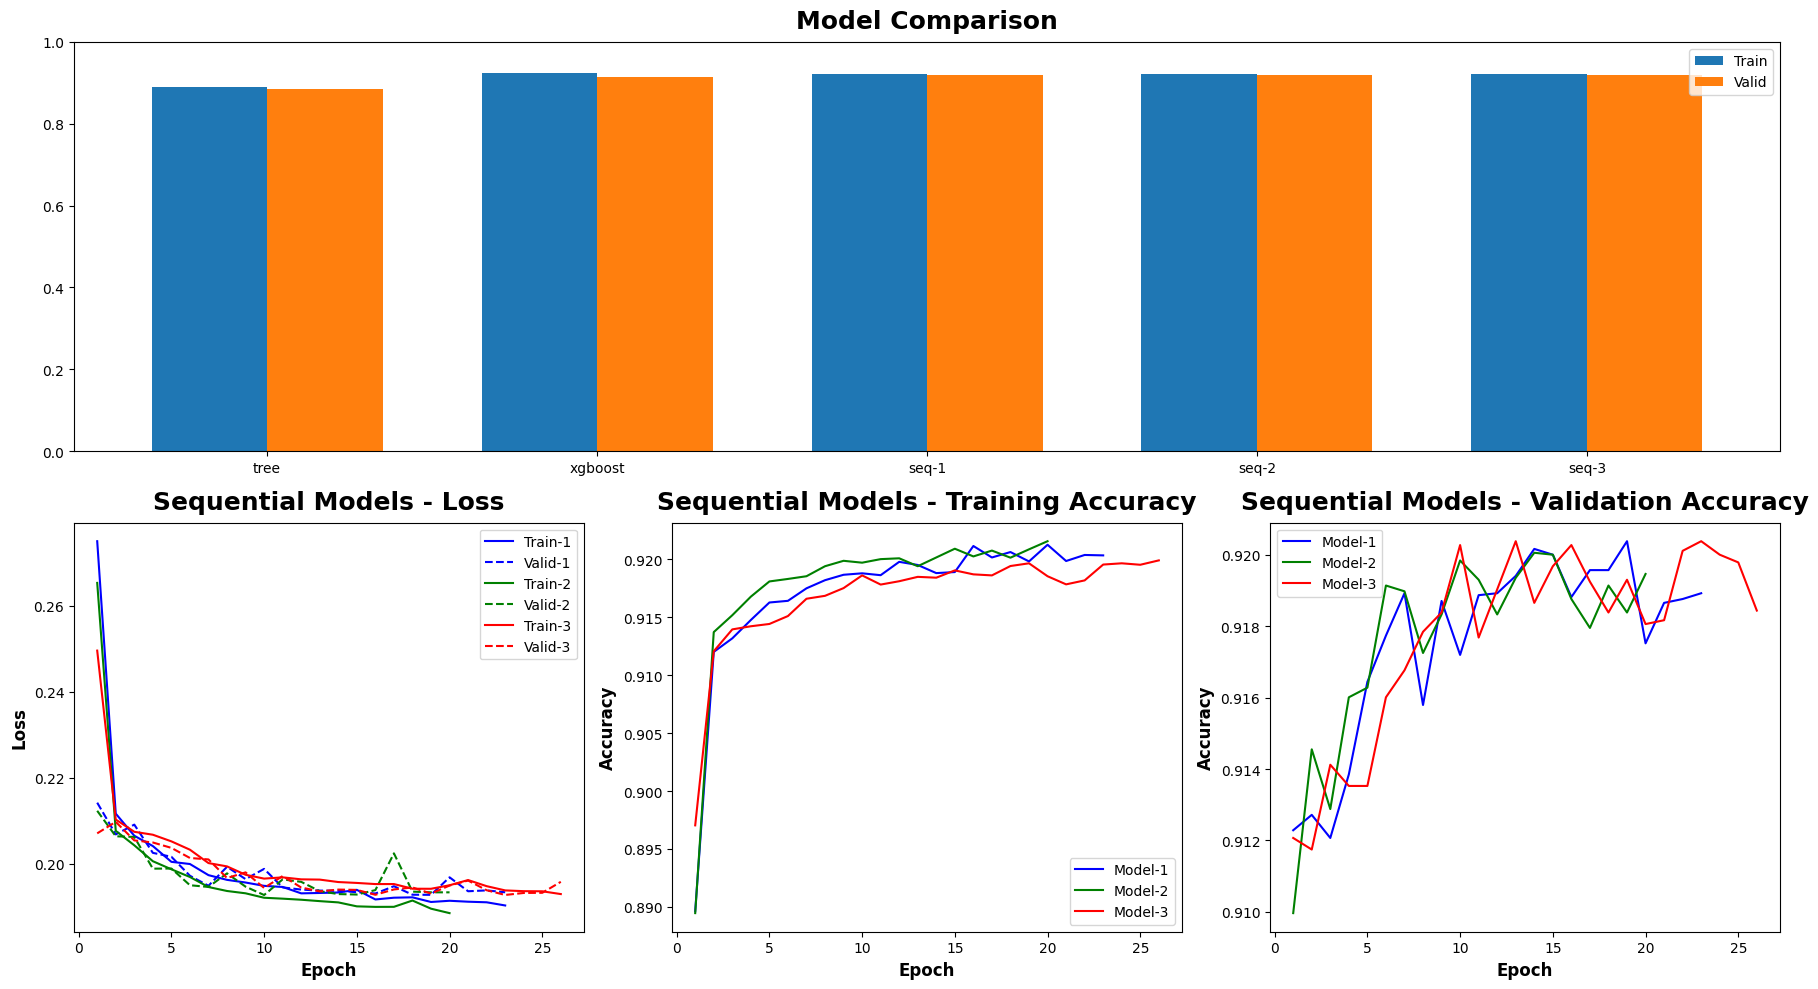

In [18]:
bot_models = get_models(bot_input_shape[0])
bot_models, bot_results, bot_best_model_type, bot_best_model, bot_best_seq_key = train_models(
    bot_X_train, bot_X_valid, bot_y_train, bot_y_valid, bot_models, 
    epochs=100, batch_size=256
)

# Visualize bot results
fig = visualize_model_results(bot_results, bot_best_model_type, bot_best_seq_key)

## Save models

In [19]:
import os
import joblib
    
def save_all_models():
    os.makedirs('role_models', exist_ok=True)
    
    top_best_model.save('role_models/top_model.keras')
    jungle_best_model.save('role_models/jungle_model.keras')
    mid_best_model.save('role_models/mid_model.keras')
    sup_best_model.save('role_models/sup_model.keras')
    bot_best_model.save('role_models/bot_model.keras')
    
def save_tools():
    os.makedirs('tools', exist_ok=True)
    
    joblib.dump(win_loose_preprocessor, 'tools/win_loose_preprocessor.pkl')
    
save_all_models()
save_tools()